In [ ]:
import json
import urllib
import pandas as pd
import io
import math
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from collections import Counter, defaultdict
import spacy


In [ ]:
train_link = "https://raw.githubusercontent.com/DenisPeskov/2020_acl_diplomacy/master/data/train.jsonl"
test_link = "https://raw.githubusercontent.com/DenisPeskov/2020_acl_diplomacy/master/data/test.jsonl"
validation_link = "https://raw.githubusercontent.com/DenisPeskov/2020_acl_diplomacy/master/data/validation.jsonl"

links_names_dict = {"train": train_link , "test": test_link, "validation": validation_link}

def pull_and_dump_to_csv(link, name):
    '''
    Pull .jsonl from GitHub and dump it into a .csv
    '''
    
    with urllib.request.urlopen(link) as f:
        df_final = pd.DataFrame(json.loads(line) for line in f)
        df_final['new_index'] = df_final['game_id'].astype(str) + "_" + df_final.index.astype(str)
        df_final = df_final.set_index('new_index').apply(lambda x: x.apply(pd.Series).stack()).reset_index().drop('level_1', 1)
        df_final[['game','index']] = df_final.new_index.apply(lambda x: pd.Series(str(x).split("_")))
        df_final = df_final.reset_index()
        df_final = df_final.drop(columns=['game_id', 'players', 'new_index', 'index', 'level_0'])
        df_final = df_final.sort_values(by=['absolute_message_index'])
        df_final = df_final.dropna(how='any')
        df_final.to_csv(f'{name}.csv', index=False)

#for name, link in links_names_dict.items():
    #pull_and_dump_to_csv(link, name)
    #print(name)

In [ ]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_test = pd.read_csv('test.csv')

In [ ]:
df_val = pd.read_csv('validation.csv')

In [ ]:
df_train.head(15)

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game
0,Hello there! What's your general plan for this...,True,True,austria,turkey,0.0,0.0,Spring,1901,3,0,1
1,"Hello France, world you like to discuss workin...",False,True,england,france,0.0,0.0,Spring,1901,3,0,10
2,Hello Italy! I chose you as the first country ...,True,True,austria,italy,0.0,0.0,Spring,1901,3,0,5
3,Hey Turkey! How are you doing? Looking forward...,True,True,austria,turkey,0.0,0.0,Spring,1901,3,0,2
4,"So, I'm proposing a northern triple. You, me, ...",True,True,russia,england,0.0,0.0,Spring,1901,4,1,3
5,Greetings and salutations! I prefer not to bo...,True,True,russia,austria,0.0,0.0,Spring,1901,4,1,7
6,Greetings Russia ! I have a proposal for you,True,True,turkey,russia,0.0,0.0,Spring,1901,3,-1,9
7,"Bounce in black, I assume? Or is there anythi...",True,True,turkey,russia,0.0,0.0,Spring,1901,3,-1,8
8,"Hello Turkey, nice to make your acquaintance. ...",True,True,russia,turkey,0.0,0.0,Spring,1901,4,1,6
9,"Hey Germany, would you like to work together?",True,True,england,germany,1.0,0.0,Spring,1901,3,0,10


In [ ]:
print(f"Total number of Rows: {df_train.shape[0] + df_test.shape[0] + df_val.shape[0]}")

Total number of Rows: 17289


In [ ]:
grouped_labels = df_train.groupby(['game', 'sender_labels']).agg({'sender_labels': 'count'})
grouped_labels_percentage = grouped_labels.groupby(level=0).apply(lambda x:
                                                                 x / float(x.sum()))

In [ ]:
grouped_labels

sender_labels
game sender_labels               
1    False                    219
     True                    2399
2    False                     78
     True                    3224
3    False                     45
     True                    1869
5    False                     41
     True                     386
6    False                     50
     True                     471
7    False                     45
     True                     958
8    False                     27
     True                     878
9    False                     56
     True                    1555
10   False                     30
     True                     801

In [ ]:
grouped_labels_percentage

sender_labels
game sender_labels               
1    False               0.083652
     True                0.916348
2    False               0.023622
     True                0.976378
3    False               0.023511
     True                0.976489
5    False               0.096019
     True                0.903981
6    False               0.095969
     True                0.904031
7    False               0.044865
     True                0.955135
8    False               0.029834
     True                0.970166
9    False               0.034761
     True                0.965239
10   False               0.036101
     True                0.963899

#### EDA

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   messages                13132 non-null  object 
 1   sender_labels           13132 non-null  bool   
 2   receiver_labels         13132 non-null  object 
 3   speakers                13132 non-null  object 
 4   receivers               13132 non-null  object 
 5   absolute_message_index  13132 non-null  float64
 6   relative_message_index  13132 non-null  float64
 7   seasons                 13132 non-null  object 
 8   years                   13132 non-null  int64  
 9   game_score              13132 non-null  int64  
 10  game_score_delta        13132 non-null  int64  
 11  game                    13132 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(5)
memory usage: 1.1+ MB


In [ ]:
descr_sum = df_train.describe()
descr_sum

,absolute_message_index,relative_message_index,years,game_score,game_score_delta,game
count,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000,13132.000000
mean,1026.960021,120.646512,1903.535029,5.326226,0.071429,4.363006
std,813.861939,139.004464,2.373907,2.049506,2.150761,3.184507
min,0.000000,0.000000,1901.000000,0.000000,-14.000000,1.000000
25%,364.000000,23.000000,1902.000000,4.000000,-1.000000,2.000000
50%,802.000000,66.000000,1903.000000,5.000000,0.000000,3.000000
75%,1540.000000,159.000000,1905.000000,6.000000,1.000000,8.000000
max,3301.000000,674.000000,1910.000000,17.000000,14.000000,10.000000


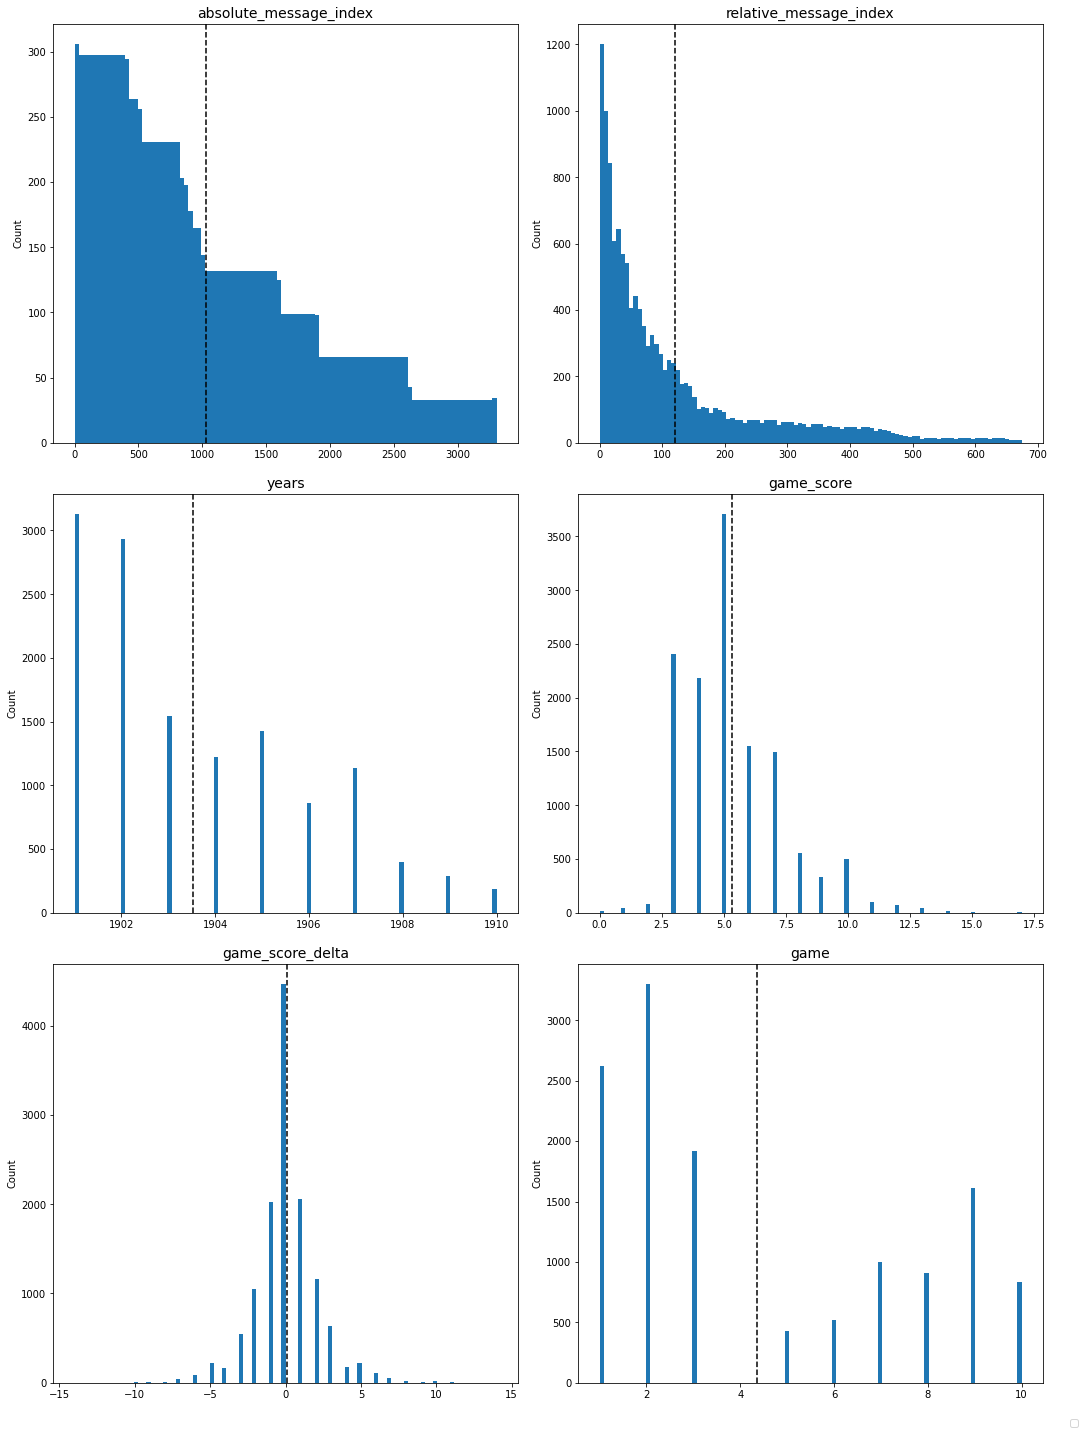

In [ ]:
def mulitple_hist(df,columns, n_col = 2):
    n_row = math.ceil(len(columns)/2)
    column_index = 0
    fig, axes = plt.subplots(n_row, n_col, figsize=(15,20))
    fig.tight_layout(pad=3.0)
    if len(columns)%2 >0:  
        fig.delaxes(axes[n_row-1][n_col-1])

    for col, ax in zip(columns, axes.flatten()):
            ax.hist(df[col], bins= 100)
            ax.set_title(col, fontsize=14)
            ax.set_ylabel('Count')
            mean_line = ax.axvline(df[col].mean(), color='black', linestyle='--')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower right' )
    plt.show()




#numerical_columns = df.columns[df.dtypes != 'object']
#print(numerical_columns)
mulitple_hist(df_train,df_train.select_dtypes('number').columns)

In [ ]:
df_train.isnull().sum()

messages                  0
sender_labels             0
receiver_labels           0
speakers                  0
receivers                 0
absolute_message_index    0
relative_message_index    0
seasons                   0
years                     0
game_score                0
game_score_delta          0
game                      0
dtype: int64

#### Data Processing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Add word type count | Doc-Characteristics

In [ ]:
def doc_characteristics(df):

    tag_keys = ['ADJ','ADP', 'ADV', 'AUX', 'INTJ','CONJ','NOUN','DET','PROPN','NUM','VERB','PART','PRON','SCONJ']
    cols = tag_keys[:]
    cols.append("No_sents")
    cols.append("No_chars")
    df_tags = pd.DataFrame(columns = cols)

    
    for i in range(df.shape[0]):

        char_count = 0
        tag_counter = defaultdict(lambda : 0)
        #for key in tag_keys:
            #tag_counter[key]
        
        corpus_sent = nltk.sent_tokenize(df['messages'][i])

        for sent in corpus_sent:
            doc = nlp(sent)

            for token in doc:
                tag_counter[token.pos_]+= 1

            #Char Count
            tokens = nltk.word_tokenize(sent)
            for t in tokens:
                char_count += len(list(t))

            
        avg_count_list = list()
        for key in tag_keys:
            if tag_counter[key] > 0:
                count_avg_sentence = tag_counter[key]/ len(corpus_sent)
                avg_count_list.append(count_avg_sentence)
            else:
                avg_count_list.append(0)

        avg_count_list.append(len(corpus_sent))
        avg_count_list.append(char_count)

        tag_row = pd.Series(avg_count_list, index=cols)
        df_tags = df_tags.append(tag_row, ignore_index=True)

    return df_tags

df_train = pd.concat([df_train,doc_characteristics(df_train)], axis=1)
df_val = pd.concat([df_val,doc_characteristics(df_val)], axis=1)
df_test = pd.concat([df_test,doc_characteristics(df_test)], axis=1)

#### Remove Stopping Words etc.

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    
    #lemmatization & country anonymization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    text_list =[]
    for t in tokens:
        text_list.append(lemmatizer.lemmatize(t))
    text = ' '.join(text_list)
    
    return text

In [ ]:
df_train['messages'] = df_train['messages'].apply(clean_text)
df_train['messages'] = df_train['messages'].str.replace('\d+', '')
df_val['messages'] = df_val['messages'].apply(clean_text)
df_val['messages'] = df_val['messages'].str.replace('\d+', '')
df_test['messages'] = df_test['messages'].apply(clean_text)
df_test['messages'] = df_test['messages'].str.replace('\d+', '')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


#### Anonymisation of Country Names 

In [ ]:
def country_anonymisation(df):
    for index in range(df.shape[0]):
        
        #Receiver
        rec_str = df["receivers"][index]
        rec_str +=  str(df["game"][index])
        df[index, "receivers"] = rec_str
        
        #Speaker
        sen_str = df["speakers"][index]
        sen_str +=  str(df["game"][index])
        df.loc[index, "speakers"] = sen_str
        
        #Messages
        message = []
        for sent in  nltk.sent_tokenize(df['messages'][index]):
            sent = sent.lower()
            for token in nltk.word_tokenize(sent):
                if token in ['austria', 'italy', 'germany', 'turkey', 'france', 'england', 'russia']:

                    token +=  str(df["game"][index])
                message.append(token)    

        df.loc[index, "messages"] = sen_str = TreebankWordDetokenizer().detokenize(message)

In [ ]:
df_train = country_anonymisation(df_train)
df_val = country_anonymisation(df_val)
df_test = country_anonymisation(df_test)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

#### Dummy Columns


In [ ]:
def dummy_columns(df):

    column_to_dummies = [
        'speakers',
        'receivers',
        'seasons',
    ]
    
    df = pd.concat([df, pd.get_dummies(df[column_to_dummies])], axis=1)
    df = df.drop(columns=column_to_dummies)

    return df

df_train = dummy_columns(df_train)
df_val = dummy_columns(df_val)
df_test = dummy_columns(df_test)


In [ ]:
def label_class(df):
    df['sender_labels'] = df.sender_labels.astype(int)
    df.rename(columns = {"sender_labels": "class"}, inplace=True)
    return df


df_train = label_class(df_train)
df_val = label_class(df_val)
df_test = label_class(df_test)

##### Final preprocessed Dataset

In [ ]:
df_train.to_csv("train_preprocessed.csv", index=False)
df_val.to_csv("validation_preprocessed.csv", index=False)
df_test.to_csv("test_preprocessed.csv", index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d30aab93-185d-4715-858f-78b8c83c5d5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>